In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tempfile import mkdtemp
from shutil import rmtree
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


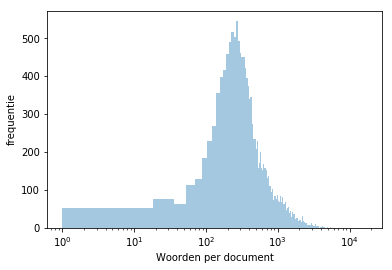

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


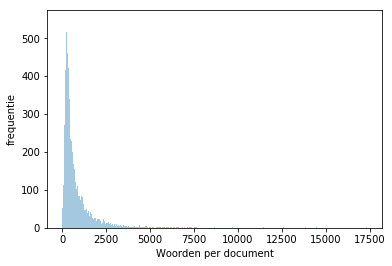

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


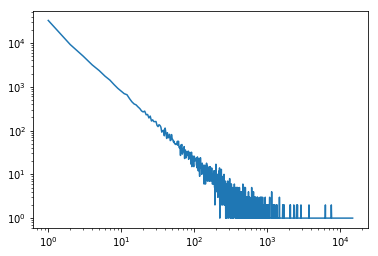

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.13      0.14      0.13      1901
ChristenUnie       0.07      0.07      0.07      1068
         D66       0.12      0.13      0.12      1889
  GroenLinks       0.07      0.07      0.07      1068
         PVV       0.10      0.10      0.10      1700
        PvdA       0.14      0.14      0.14      1821
        PvdD       0.02      0.02      0.02       432
         SGP       0.04      0.04      0.04       655
          SP       0.15      0.15      0.15      2284
         VVD       0.10      0.10      0.10      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [ ]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [ ]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    if text_dict[name]:
         text = df.stemmed_text
    else:
        text = df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [41]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classifaction_report_csv(report,save):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-1]:
        row = {}
        row_data = line.split('      ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5]
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1_score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall","F1_score","Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    print(as_list)

    idx = as_list.index(' avg / total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [13]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [14]:
def traintest3(pipe, stem, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(classification_report(test.party, predicted),False)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe, cnf_matrix, report, accuracy
    

def traintest(file, data, save=False, params=None):
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    pipe, cnf_matrix, report, accuracy = traintest3(base_pipe, stem, data, save=False)
    for x in tqdm(range(4)):
        _, cnf_matrix2, report2, accuracy2 = traintest3(base_pipe, stem, data, save=False)
        cnf_matrix = np.add(cnf_matrix,cnf_matrix2)
        report = report.add(report2, fill_value=0)
        accuracy += accuracy2
    accuracy /=5
    cnf_matrix = np.divide(cnf_matrix,5)
    report /=5
     
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipe



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:57<00:00, 89.32s/it]


              Precision  Recall  F1_score  Documenten
50PLUS            0.896   0.862     0.880        73.8
   CDA            0.782   0.768     0.774       379.8
ChristenUnie      0.840   0.752     0.790       219.0
   D66            0.788   0.692     0.736       385.0
  GroenLinks      0.820   0.746     0.780       210.0
   PVV            0.774   0.860     0.816       342.6
  PvdA            0.730   0.660     0.686       362.6
  PvdD            0.874   0.818     0.840        87.6
   SGP            0.782   0.808     0.790       134.8
    SP            0.724   0.828     0.770       449.2
   VVD            0.702   0.716     0.704       335.6
Totaal            0.770   0.764     0.762      2980.0


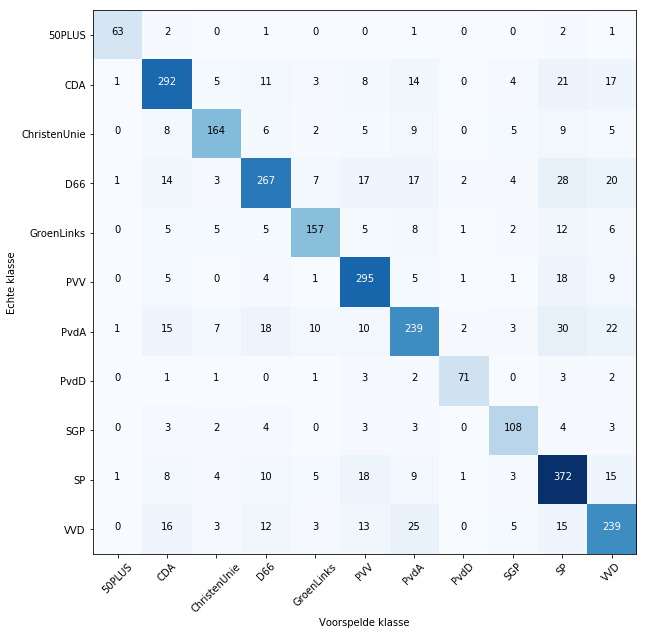

In [15]:
pipe = traintest('Scores.xlsx', df ,save="confusionmatrix")

In [16]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

In [17]:
mostimportantwords(pipe, countdf, filename='MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,het lid ouwehand,de sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,lid ouwehand,sgp,de sp,vvd
2,lid krol nar,cda fractie,het lid dik,lid van veldhov,het lid voortman,islamitisch,pvda fractie,lid ouwehand nar,sgp fractie,sp fractie,de vvd fractie
3,lid krol,de cda fractie,lid dik,lid van men,lid voortman nar,het lid graus,de partij van,ouwehand nar mij,de sgp fractie,de sp fractie,vvd fractie
4,krol nar,de cda,lid dik faber,d66 wil,lid voortman,lid graus,van de arbeid,ouwehand nar,led dijkgraf,lid van gerv,de vvd is
5,krol nar mij,lid omtzigt nar,led dik faber,d66 is,led van tonger,lid graus nar,de pvda fractie,ouwehand,de led dijkgraf,lid smaling,vvd is
6,van 50plus,lid omtzigt,de led dik,van veldhov,tonger nar mij,miljard,de arbeid,vor de dier,led van der,het lid smaling,vor de vvd
7,krol,het lid omtzigt,led dik,veldhov,tonger nar,brussel,partij van de,de dier,led bisschop,lid smaling nar,wat de vvd
8,50plus is,het cda is,de led voordewind,led schouw,van tonger nar,nederland,partij van,thiem,de led bisschop,van gerv nar,vvd vindt
9,gepensioneerd,cda is,led voordewind,de led schouw,led voortman,graf,arbeid,dier,de sgp is,gerv nar mij,de vvd vindt


# Without Names

In [18]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:48<00:00, 87.05s/it]


              Precision  Recall  F1_score  Documenten
50PLUS            0.696   0.454     0.550        76.0
   CDA            0.604   0.264     0.364       400.6
ChristenUnie      0.512   0.302     0.362       221.0
   D66            0.488   0.402     0.436       360.8
  GroenLinks      0.544   0.338     0.408       209.8
   PVV            0.486   0.804     0.602       337.4
  PvdA            0.412   0.438     0.400       372.2
  PvdD            0.628   0.564     0.588        89.6
   SGP            0.576   0.640     0.588       126.4
    SP            0.484   0.600     0.526       454.0
   VVD            0.406   0.454     0.428       332.2
Totaal            0.506   0.470     0.458      2980.0


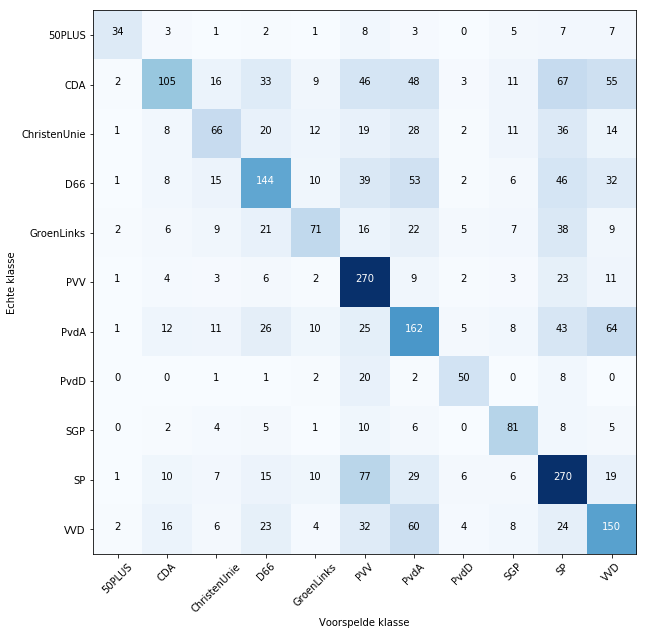

In [19]:
pipe = traintest('Scores.xlsx', df, save="withoutnames")

In [20]:
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,inwoner,gezinn met,mijn fractie,schon energie,islamitisch,ieder kind,bio industrie,mevrouw de voorzitter,segregatie,aruba
1,50 plusser,PARTIJ fractie,het ingezetenencriterium,buitengewon,schon,miljard,circulair,de bio industrie,mevrouw de,herindel,essentieel
2,koopkrachtontwikkel,juridisch loket,voedselverspill,kans,banenplan,brussel,open standaard,de bio,allereerst,huurder,speelveld
3,plusser,zorginstell,rookvrij,vingerafdruk,kamer hierover te,nederland,pakketbezorger,bio,eenverdiener,armoed,liberal
4,50,risicovereven,ingezetenencriterium,hervorm,sekswerker,islam,mijn partij,industrie,oog,de bevolk,volgen mij
5,vor gepensioneerd,antwoord,koerd,onderbouw,voorzitter motie de,verzorgingshuiz,gezamen,aan de bio,punt,ouderbijdrag,regelgev
6,de koopkrachtontwikkel,middeninkomen,gezinn,expliciet,voorzitter motie,de islam,eigenar,dier,benader,bevolk,vor PARTIJ
7,werkend,het juridisch loket,politievrijwilliger,daarom,zou,belastingbetaler,punt is,klimaatverander,beantwoord,zegt,haatprediker
8,leeftijdsdiscriminatie,onz inwoner,inderdad,natur,belastingontwijk,dit kabinet,en,de veehouderij,allerlei,afbraakplan,kader
9,themakanal,verdring,begeleid,ding,vergroen,de verzorgingshuiz,hulpverlener,moet kom aan,woord,groeiend,administratiev last


# Only Names

In [21]:
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["stemmed_text"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,names
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,devvd depvda vvd depvv rutte rutte rutte samso...,mevrouw de voorzitter dit kabinet heeft ons mo...,"[de VVD, de PvdA, VVD, de PVV, Rutte, Rutte, R..."
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,samsom rutte rutte samsom rutte samsom,voorzitter vorige week plaatsten werkgevers we...,"[Samsom, Rutte, Rutte, Samsom, Rutte, Samsom]"
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,d66 pvda d66 d66 rutte samsom,voorzitter twee maanden geleden kreeg dit kabi...,"[D66, PvdA, D66, D66, Rutte, Samsom]"
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,decda hetcda hetcda hetcda hetcda pechtold sam...,voorzitter alleen al in de eerste drie maanden...,"[de CDA, het CDA, het CDA, het CDA, het CDA, P..."
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,vvd pvda pvda devvd departijvandearbeid samsom...,voorzitter we zijn eruit eerst ontdekte de min...,"[VVD, PvdA, PvdA, De VVD, de Partij van de Arb..."


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


              Precision  Recall  F1_score  Documenten
50PLUS            0.800   0.814     0.808        72.0
   CDA            0.608   0.652     0.618       369.4
ChristenUnie      0.572   0.614     0.572       215.2
   D66            0.642   0.498     0.562       386.0
  GroenLinks      0.684   0.680     0.680       218.6
   PVV            0.706   0.668     0.686       339.2
  PvdA            0.620   0.482     0.540       357.4
  PvdD            0.670   0.792     0.688        85.6
   SGP            0.680   0.510     0.582       129.4
    SP            0.624   0.634     0.618       464.0
   VVD            0.600   0.582     0.576       343.2
Totaal            0.640   0.604     0.614      2980.0


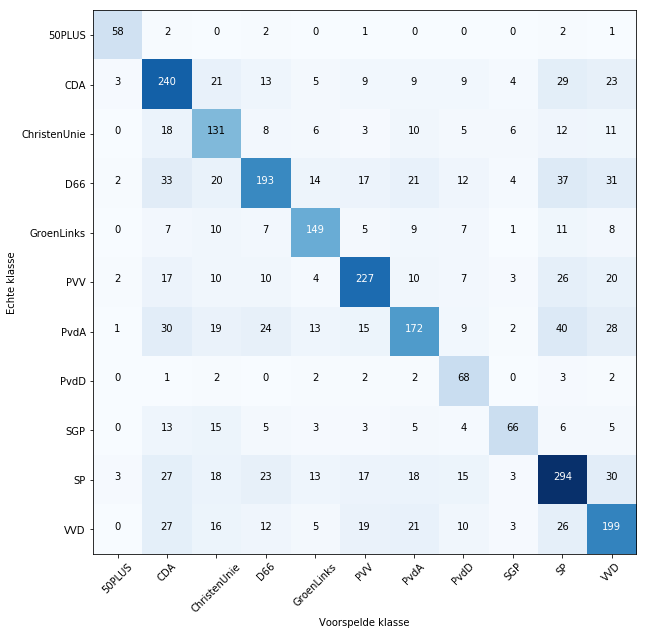

In [22]:
pipe = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1)})

In [23]:
mostimportantwords(pipe, countdf, filename='onlynames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,decda,dechristenunie,d66,groenlinks,depvv,departijvandearbeid,departijvoordedieren,desgp,smaling,devvd
1,de50plus,hetcda,dik,belhaj,vantongeren,tonyvandijck,depvda,ouwehand,sgp,desp,rudmerheerema
2,krol,vanhelvert,faber,ded66,degroenlinks,departijvoordevrijheid,albertdevries,depvdd,vanderstaaij,jaspervandijk,remcodijkstra
3,klein,ronnes,segers,vanveldhoven,grashoff,klever,cegerek,wassenberg,amhaouch,paulusjansen,aukjedevries
4,smits,agnesmulder,schouten,piadijkstra,vanojik,madlener,janvos,thieme,houwers,merkies,ziengs
5,timmerman,cda,voordewind,koşerkaya,klaver,degraaf,jadnanansing,pvdd,bisschop,siderius,venrooy
6,vanmiltenburg,keijzer,bruins,vanmeenen,voortman,hetpvv,wolbert,hetpvda,hilkens,vangerven,straus
7,vandijk,geurts,christenunie,hachchi,ellemeet,fritsma,jacobi,öztürk,tanamal,leijten,welkzijn
8,pvda,vanhaersmabuma,geselschap,bergkamp,hetvvd,gerbrands,meilivos,martinbosma,verheijen,bashir,remcobosma
9,vanhaersmabuma,bruinsslot,slob,schouw,christenunie,wilders,leenders,moors,koolmees,kooiman,vanmiltenburg


# Confusion matrix analyse

In [24]:
def traintest2(file, data, save=False):
    train, test = data
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)

    return pipe, oppositie, regering, mix, ggg

In [25]:
o = []
m = []
r = []
g = {}
for i in tqdm(range(10)):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.xlsx', train_test_split(df, test_size=0.2))
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.40s/it]


(0.9151799448967489, 1.1943859757925584e-41)

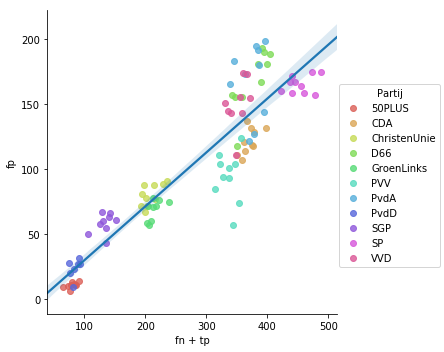

In [26]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='fn + tp')
values = pd.Series(values,name='fp')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: -0.7489372856533802
NormaltestResult(statistic=653.5443132537739, pvalue=1.2152217595272224e-142)


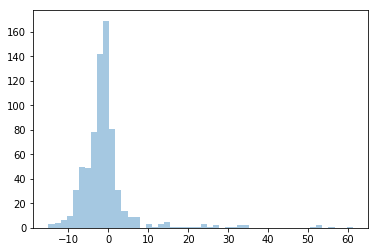

In [27]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable(o))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


7.7390199100981265

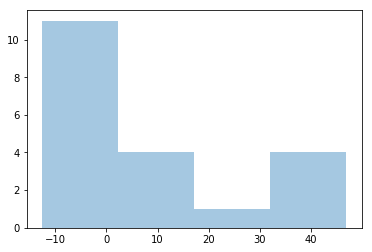

In [28]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.0679290207457535

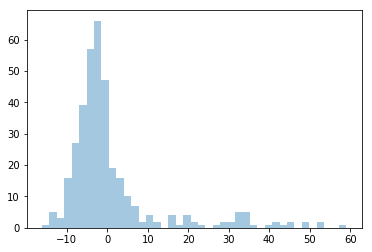

In [29]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.0
NormaltestResult(statistic=763.3084410950646, pvalue=1.7769615111419554e-166)


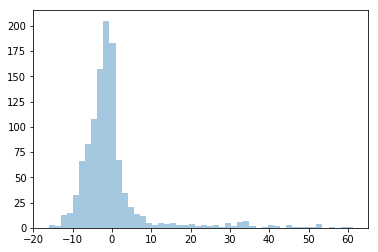

In [30]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(list(chain.from_iterable(m+o+r))))

In [31]:
scipy.stats.normaltest(list(chain.from_iterable(m+o+r)))

NormaltestResult(statistic=763.3084410950646, pvalue=1.7769615111419554e-166)

# Woorden Balkenende 4

In [32]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text
5316,Thieme,PvdD,Mevrouw de voorzitter. Wij hebben te maken met...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij hebb te mak met een ...
5446,Marijnissen,SP,Mevrouw de voorzitter. Na de feestrede van de ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter na de feestred van de mi...
5447,Van Geel,CDA,Mevrouw de voorzitter. Ik dank de minister-pre...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ik dank de minister pres...
5448,Rutte,VVD,Mevrouw de voorzitter. Ook ik dank de regering...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ook ik dank de reger gra...
5449,Tichelaar,PvdA,Voorzitter. Ik dank de minister-president voor...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter ik dank de minister president vor z...


In [33]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1039
ChristenUnie     561
D66              518
GroenLinks       760
PVV              971
PvdA             903
PvdD             165
SGP              507
SP              1222
VVD             1041
Name: party, dtype: int64

In [34]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
5316,Thieme,PvdD,Mevrouw de voorzitter. Wij hebben te maken met...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij hebb te mak met een ...,mevrouw de voorzitter wij hebben te maken met ...
5446,Marijnissen,SP,Mevrouw de voorzitter. Na de feestrede van de ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter na de feestred van de mi...,mevrouw de voorzitter na de feestrede van de m...
5447,Van Geel,CDA,Mevrouw de voorzitter. Ik dank de minister-pre...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ik dank de minister pres...,mevrouw de voorzitter ik dank de minister pres...
5448,Rutte,VVD,Mevrouw de voorzitter. Ook ik dank de regering...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ook ik dank de reger gra...,mevrouw de voorzitter ook ik dank de regering ...
5449,Tichelaar,PvdA,Voorzitter. Ik dank de minister-president voor...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter ik dank de minister president vor z...,voorzitter ik dank de minister president voor ...


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:57<00:00, 44.38s/it]


              Precision  Recall  F1_score  Documenten
   CDA            0.446   0.608     0.506       208.8
ChristenUnie      0.512   0.410     0.436       117.4
   D66            0.616   0.336     0.428       101.0
  GroenLinks      0.548   0.512     0.524       148.8
   PVV            0.604   0.662     0.626       199.2
  PvdA            0.434   0.294     0.342       178.0
  PvdD            0.570   0.390     0.462        30.6
   SGP            0.612   0.830     0.700        97.4
    SP            0.496   0.600     0.542       243.0
   VVD            0.468   0.320     0.374       213.8
Totaal            0.520   0.508     0.494      1538.0


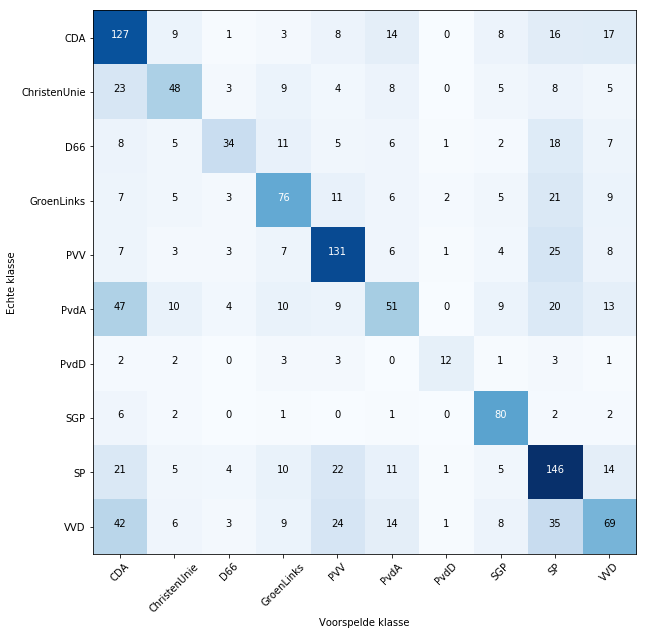

In [35]:
pipe = traintest('Scores.xlsx', dfb4)

In [36]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,PARTIJ fractie,fractie van PARTIJ,dadelijk,PARTIJfractie,turk,roc,bio industrie,uitdruk,lerar,onz fractie
1,wij,moment,schon energie,deal,burger,belangrijk,de bio,mijn fractie,zegt,PARTIJ
2,zorgvuld,de fractie van,hervorm,politiek,immigratie,in dit,de bio industrie,wel,papier,liberal
3,KAMERLID,geweest,arbeidsmarkt,fractie van PARTIJ,de burger,medewerker,bio,beantwoord,personel,timmerman
4,buitengewon,de fractie,woningmarkt,premier,gewon,vrouw,dier,positief,mens,prat
5,kliniek,mijn fractie,generaties,je zou,onz,de roc,dierenwelzijn,diver,leerling,fractie
6,aangegev,fractie van,de arbeidsmarkt,klimaatverander,belastinggeld,de werkgroep,dierproev,dankzegg vor,thuiszorg,voorzitter PARTIJ fractie
7,wij hebb,PARTIJfractie,ik hop,klimaatcrisis,miljard,gezegd,landbouwareaal,voorzitter ik wil,voorstell,markt
8,PARTIJ fractie heeft,volgen mij,patient,lijkt,vreemdel,volgen mij,aan de bio,dankzegg,ruimtelijk,de her timmerman
9,via,direct,hop,goed nieuw,natur,geweld,kiezer,wil grag de,fatsoen,her timmerman


# Vergelijken

In [37]:
def traintest(file, data, save=False):
    pipe, stem = getbestpipe(file)
    train, test = data
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(classification_report(test.party, predicted),False)
    print(report)
    accuracy = accuracy_score(test.party, predicted)
    print(accuracy)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe

In [38]:
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM') for t in tokenizer.tokenize(x)]))
df['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM') for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


In [39]:
pipe = traintest('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal")

              Precision  Recall  F1_score  Documenten
   CDA             0.31    0.13      0.18        1039
ChristenUnie       0.28    0.18      0.22         561
   D66             0.15    0.11      0.13         518
  GroenLinks       0.16    0.19      0.18         760
   PVV             0.38    0.65      0.48         971
  PvdA             0.27    0.22      0.25         903
  PvdD             0.57    0.47      0.51         165
   SGP             0.39    0.53      0.45         507
    SP             0.36    0.51      0.42        1222
   VVD             0.16    0.10      0.12        1041
Totaal             0.29    0.31      0.28        7687
0.3050604917393001


In [42]:
pipe = traintest('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut")

['   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD']


ValueError: ' avg / total' is not in list

# Links / Rechts vergelijken

In [ ]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
pipe, _ = getbestpipe('Scores.xlsx')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

# Taalgebruik van sprekers

In [43]:
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


In [44]:
def traintest3(pipe, stem, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(classification_report(test.party, predicted),False)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe, cnf_matrix, report, accuracy
    

def traintest(file, data, save=False, params=None):
    n = 10
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    pipe, cnf_matrix, report, accuracy = traintest3(base_pipe, stem, data, save=False)
    for x in tqdm(range(n-1)):
        _, cnf_matrix2, report2, accuracy2 = traintest3(base_pipe, stem, data, save=False)
        cnf_matrix = np.add(cnf_matrix,cnf_matrix2)
        report = report.add(report2, fill_value=0)
        accuracy += accuracy2
    accuracy /=n
    cnf_matrix = np.divide(cnf_matrix,n)
    report /=n
     
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipe

['Houwers' 'Ziengs' 'Schut-Welkzijn' 'Samsom' 'Koser Kaya' 'Bashir'
 'Heerema' 'Van Raak' 'Vermeij' 'Rebel' 'Vermue' 'Siderius' 'Klein'
 'Van der Staaij' 'Koolmees' 'Azmani' 'Krol' 'Oosenbrug' 'Voortman'
 'De Boer' 'Schouten' 'Wassenberg' 'Keijzer' 'Klaver' 'Mei Li Vos'
 'Otwin van Dijk' 'Van Weyenberg' 'Graus' 'Mohandis' 'Hachchi' 'Heerma'
 'Tony van Dijck' 'Ypma' 'Ronnes' 'Van Helvert' 'Karabulut' 'Agnes Mulder'
 'Heijnen' 'Lucas' 'Ouwehand' 'Van Veldhoven' 'Marcouch' 'Klever'
 'Grashoff' 'Volp' 'De Graaf' 'Bosman' 'Geurts' 'Omtzigt' 'Van der Linde'
 'Huizing' 'Belhaj' 'Van Veen' 'Maij' 'Van Nieuwenhuizen-Wijbenga'
 'Van Toorenburg' 'Rog' 'Wolbert' 'Remco Dijkstra' 'De Rouwe' 'Litjens'
 'Oskam' 'Kerstens' 'De Lange' 'Van Nispen' 'Leijten' 'Neppérus' 'Teeven'
 'Martin Bosma' 'Lodders' 'Jan Vos' 'Slob' 'Berckmoes-Duindam'
 'Jadnanansing' 'Schouw' 'Madlener' 'Remco Bosma' 'Recourt' 'Verhoeven'
 'Wilders' 'Nijkerken-de Haan' 'Van Wijngaarden' 'Kuzu' 'Fokke' 'Dikkers'
 'Van Gerven' 'De Ca

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

['Schut-Welkzijn' 'Ziengs' 'Moors' 'Dik-Faber' 'De Caluwé' 'Pechtold'
 'Litjens' 'Van Klaveren' 'Van Ark' 'Wilders' 'De Rouwe' 'Krol' 'Knops'
 'Hachchi' 'Bruins' 'Pia Dijkstra' 'Hilkens' 'Van Nispen' 'Van Weyenberg'
 'Verheijen' 'Günal-Gezer' 'Taverne' 'Yücel' 'Swinkels' 'Maij' 'Ouwehand'
 'Van Miltenburg' 'Groot' 'Sjoerdsma' 'Samsom' 'Jan Vos' 'Rudmer Heerema'
 'Graus' 'Van Laar' 'Koşer Kaya' 'Elias' 'Nijkerken-de Haan' 'Dijkgraaf'
 'Neppérus' 'De Graaf' 'Tanamal' 'Vermue' 'Ten Broeke' 'Van der Burg'
 'Rutte' 'Kuiken' 'Vermeij' 'Merkies' 'Öztürk' 'Kuzu' 'Van Bommel'
 'Gerbrands' 'Azmani' 'Cegerek' 'Van Haersma Buma' 'Mei Li Vos'
 'Van Oosten' 'Nijboer' 'Agnes Mulder' 'Van Toorenburg' 'Bruins Slot'
 'Belhaj' 'Slob' 'Helder' 'Van Dam' 'Klein' 'Asante' 'Van Tongeren'
 'Omtzigt' 'Van Hijum' 'Van Nieuwenhuizen-Wijbenga' 'Van der Ree'
 'Brouwer' 'Aukje de Vries' 'Bergkamp' 'Amhaouch' 'Van der Linde'
 'Remco Bosma' 'Klever' 'Madlener' 'Schouten' 'Fokke' 'Bosman' 'Hoogland'
 'De Wit' 'Karabul

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 11%|█████████▎                                                                          | 1/9 [01:27<11:38, 87.26s/it]

['Maij' 'Van Raak' 'Mohandis' 'Van Bommel' 'Van Dekken' 'Oosenbrug'
 'Madlener' 'Heerema' 'Eijsink' 'Ulenbelt' 'Brouwer' 'Bosma' 'Tellegen'
 'Heijnen' 'Berndsen-Jansen' 'Dik-Faber' 'Karabulut' 'Günal-Gezer'
 'Samsom' 'Verheijen' 'Van der Velde' 'Harbers' 'Schouten' 'Monasch'
 'Bruins Slot' 'Schouw' 'Omtzigt' 'Klein' 'Jacobi' 'Helder' 'Sjoerdsma'
 'Van Ark' 'Jan Vos' 'Bonis' 'Amhaouch' 'Ten Broeke' 'Wilders' 'Krol'
 'Hamer' 'Van Tongeren' 'Fokke' 'Elias' 'Martin Bosma' 'Arib'
 'Rudmer Heerema' 'Agema' 'Thieme' 'Marcouch' 'Vuijk' 'De Caluwé'
 'Bouwmeester' 'Teeven' 'Jadnanansing' 'Koolmees' 'Berckmoes-Duindam'
 'Wolbert' 'Azmani' 'Mei Li Vos' 'Straus' 'Verhoeven' 'De Lange' 'Roemer'
 'Swinkels' 'Groot' 'De Boer' 'Vermue' 'Van Vliet' 'Dijkgraaf' 'Kuiken'
 'Koser Kaya' 'Duisenberg' 'Tony van Dijck' 'Potters' 'Bontes'
 'Otwin van Dijk' 'Grashoff' 'Hoogland' 'Pieter Heerma' 'Rog' 'Rutte'
 'Jasper van Dijk' 'Remco Bosma' 'Van Nieuwenhuizen-Wijbenga' 'Leegte'
 'Kerstens' 'Van der Burg' 'Yücel'

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 22%|██████████████████▋                                                                 | 2/9 [02:53<10:06, 86.68s/it]

['Rebel' 'Cegerek' 'Lodders' 'Recourt' 'Ypma' 'Nijkerken-de Haan' 'Moors'
 'Remco Dijkstra' 'Van Dam' 'Leijten' 'Koolmees' 'Swinkels' 'Bouwmeester'
 'Venrooy-van Ark' 'Veldman' 'Fokke' 'Anne Mulder' 'Hilkens' 'Gerbrands'
 'Dijkhoff' 'Teeven' 'Van Vliet' 'Klever' 'Verheijen' 'Martin Bosma'
 'Bruins Slot' 'Günal-Gezer' 'Schut-Welkzijn' 'Visser' 'Van Hijum'
 'Fritsma' 'Smaling' 'Kuiken' 'Rutte' 'Baay-Timmerman' 'Nijboer' 'Klein'
 'Van der Ree' 'Klaver' 'De Rouwe' 'Helder' 'Jasper van Dijk' 'Mei Li Vos'
 'Gesthuizen' 'Brouwer' 'Bosman' 'Van Wijngaarden' 'Ziengs' 'Amhaouch'
 'De Graaf' 'Rudmer Heerema' 'Jan Vos' 'Pia Dijkstra' 'Yücel' 'Leegte'
 'Van Helvert' 'Lucas' 'Hamer' 'Omtzigt' 'Thieme' 'Kooiman'
 'Paulus Jansen' 'Remco Bosma' 'Oosenbrug' 'Wilders' 'Samsom' 'De Roon'
 'Houwers' 'Neppérus' 'De Liefde' 'Agnes Mulder' 'Van Toorenburg' 'Heerma'
 'Bontes' 'Arib' 'Berndsen-Jansen' 'Vermeij' 'Otwin van Dijk' 'Heijnen'
 'Van der Steur' 'Knops' 'Jacobi' 'Straus' 'Taverne' 'Tanamal' 'Pechtold'


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 33%|████████████████████████████                                                        | 3/9 [04:17<08:35, 85.84s/it]

['Swinkels' 'Van Vliet' 'Brouwer' 'Ronnes' 'Tony van Dijck' 'Klever'
 'Rebel' 'Vermeij' 'Paulus Jansen' 'Kuiken' 'Van Klaveren' 'Yücel'
 'Hoogland' 'Van Oosten' 'Venrooy-van Ark' 'Dijkhoff' 'Karabulut' 'Maij'
 'Wilders' 'Van Nispen' 'Sjoerdsma' 'Pechtold' 'Bouwmeester' 'Mei Li Vos'
 'Van Meenen' 'Heerma' 'Jan Vos' 'Huizing' 'Verhoeven' 'Thieme'
 'Van der Linde' 'Rog' 'Voordewind' 'Straus' 'Bosma' 'Kuzu' 'Schouten'
 'Grashoff' 'Van Dam' 'Beertema' 'Koser Kaya' 'Kerstens' 'Veldman'
 'Otwin van Dijk' 'Bashir' 'Nijboer' 'Slob' 'Van der Ree' 'Cegerek'
 'Leegte' 'Schut-Welkzijn' 'Heijnen' 'Taverne' 'Van Helvert' 'Klein'
 'Helder' 'Schouw' 'Van Nieuwenhuizen-Wijbenga' 'Samsom'
 'Nijkerken-de Haan' 'Tanamal' 'Lucas' 'Monasch' 'Potters' 'Eijsink'
 'Kooiman' 'Azmani' 'Dikkers' 'Gesthuizen' 'Hachchi' 'Fokke'
 'Van Haersma Buma' 'Agnes Mulder' 'Van Gerven' 'Oosenbrug' 'Dik-Faber'
 'Segers' 'Anne Mulder' 'Ouwehand' 'Harbers' 'Elias' 'Berckmoes-Duindam'
 'Van Bommel' 'Bosman' 'Geurts' 'Merkies' 'Gün

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 44%|█████████████████████████████████████▎                                              | 4/9 [05:42<07:07, 85.55s/it]

['Leijten' 'Jadnanansing' 'Ypma' 'Oskam' 'Pia Dijkstra' 'Kerstens'
 'Van der Staaij' 'Kuzu' 'De Graaf' 'Smaling' 'Bosman' 'Geurts' 'Ziengs'
 'Albert de Vries' 'Vermue' 'Recourt' 'Potters' 'Servaes'
 'Jasper van Dijk' 'Pieter Heerma' 'Karabulut' 'Van Dekken' 'Remco Bosma'
 'Hachchi' 'Amhaouch' 'Dijkgraaf' 'Heerema' 'Ellemeet' 'Agnes Mulder'
 'Volp' 'Wolbert' 'Huizing' 'Schouw' 'Helder' 'Vermeij' 'Elias' 'Pechtold'
 'Van Laar' 'Nijkerken-de Haan' 'Van der Velde' 'Gerbrands' 'Bergkamp'
 'Bruins Slot' 'Van Tongeren' 'Bosma' 'Madlener' 'Neppérus'
 'Van Miltenburg' 'Schouten' 'Sjoerdsma' 'Klein' 'Van der Linde'
 'De Rouwe' 'Voordewind' 'Aukje de Vries' 'Verheijen' 'Fokke' 'Oosenbrug'
 'Eijsink' 'Tanamal' 'Dik-Faber' 'Azmani' 'Slob' 'Dikkers' 'Bruins'
 'Van Veldhoven' 'Samsom' 'Litjens' 'Brouwer' 'Merkies' 'Bonis' 'Voortman'
 'Van Toorenburg' 'Günal-Gezer' 'Bontes' 'Bisschop' 'Schut-Welkzijn'
 'Wilders' 'Zijlstra' 'Agema' 'Rog' 'Omtzigt' 'Koolmees' 'Moors' 'Klever'
 'Van der Steur' 'Heerma' '

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 56%|██████████████████████████████████████████████▋                                     | 5/9 [07:13<05:46, 86.65s/it]

['Hachchi' 'Baay-Timmerman' 'Wilders' 'Schouten' 'Otwin van Dijk'
 'Dikkers' 'Omtzigt' 'Karabulut' 'Jan Vos' 'Berndsen-Jansen' 'Arib'
 'Harbers' 'Anne Mulder' 'Rog' 'Koolmees' 'Hamer' 'Remco Dijkstra' 'Ypma'
 'Voortman' 'Grashoff' 'Leijten' 'Ellemeet' 'Bruins Slot' 'Mei Li Vos'
 'Van der Velde' 'De Graaf' 'Heijnen' 'Vuijk' 'Asante' 'Sjoerdsma'
 'Zijlstra' 'Van Hijum' 'Albert de Vries' 'Öztürk' 'Agema' 'Verhoeven'
 "Van 't Wout" 'Ronnes' 'Van Vliet' 'Veldman' 'Van Dekken' 'Tellegen'
 'Pieter Heerma' 'Recourt' 'Van der Staaij' 'Van Haersma Buma' 'Klein'
 'Houwers' 'Van Gerven' 'Ouwehand' 'Segers' 'Hoogland' 'Oskam'
 'Jadnanansing' 'Wolbert' 'Bergkamp' 'Van Toorenburg' 'Neppérus'
 'Kerstens' 'Klever' 'Maij' 'Van Ark' 'Roemer' 'Leegte' 'Marcouch' 'Bonis'
 'Van Weyenberg' 'Rudmer Heerema' 'Mohandis' 'Schouw' 'Gerbrands'
 'Ten Broeke' 'Van Nieuwenhuizen-Wijbenga' 'Merkies' 'Geselschap'
 'Keijzer' 'Visser' 'Bouwmeester' 'Smits' 'Brouwer' 'Thieme'
 'Pia Dijkstra' 'De Rouwe' 'Van Nispen' 'Van D

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 67%|████████████████████████████████████████████████████████                            | 6/9 [08:38<04:19, 86.48s/it]

['Karabulut' 'Rog' 'Volp' 'Hachchi' 'Vuijk' 'Thieme' 'Arib' 'Straus'
 'Pieter Heerma' 'Verhoeven' 'Van Laar' 'De Lange' 'Oskam' 'Jadnanansing'
 'Lodders' 'Sjoerdsma' 'Van Nispen' 'Voortman' 'Bashir' 'Ten Broeke'
 'Ronnes' 'Aukje de Vries' "Van 't Wout" 'Potters' 'Veldman' 'Van Gerven'
 'Berckmoes-Duindam' 'Verheijen' 'Dikkers' 'Neppérus' 'Tony van Dijck'
 'Samsom' 'Van Weyenberg' 'Bruins' 'Visser' 'Vermeij' 'Van Raak' 'Lucas'
 'Van Helvert' 'De Roon' 'Segers' 'Tellegen' 'Smits' 'Nijkerken-de Haan'
 'Eijsink' 'Van Dam' 'Koolmees' 'Wolbert' 'Heerema' 'Huizing' 'Vermue'
 'Cegerek' 'Rutte' 'Albert de Vries' 'Slob' 'De Wit' 'Servaes' 'Klaver'
 'Klever' 'Kuiken' 'Smaling' 'Schut-Welkzijn' 'Oosenbrug' 'Gesthuizen'
 'Leenders' 'Van der Steur' 'Agema' 'Keijzer' 'Nijboer' 'Moors' 'Litjens'
 'Van Toorenburg' 'Van Dekken' 'Roemer' 'Van Klaveren' 'Bergkamp'
 'Van Veen' 'Paulus Jansen' 'Yücel' 'Pechtold' 'Günal-Gezer'
 'Martin Bosma' 'Ouwehand' 'Ellemeet' 'Brouwer' 'De Liefde' 'Zijlstra'
 'Krol' 'Ja

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [10:06<02:53, 86.61s/it]

['Dikkers' 'Fokke' 'Brouwer' 'Monasch' 'Lucas' 'Van Dam' 'Otwin van Dijk'
 'Koolmees' 'Geselschap' 'De Graaf' 'Oosenbrug' 'De Caluwé' 'Nijboer'
 'Vermue' 'De Liefde' 'Kooiman' 'Leenders' 'Günal-Gezer' 'Bouwmeester'
 'Kuzu' 'Grashoff' 'Berckmoes-Duindam' 'Klein' 'Vuijk' 'Van Klaveren'
 'Geurts' 'Taverne' 'Dik-Faber' 'Volp' 'Samsom' 'Huizing' 'Van Weyenberg'
 'Amhaouch' 'Wolbert' 'Paulus Jansen' 'Madlener' 'Lodders' 'Merkies'
 'Pia Dijkstra' 'Moors' 'Maij' 'Tellegen' 'Hachchi' 'Roemer' 'Arib'
 'Pieter Heerma' 'Van Helvert' 'Van der Burg' 'Van Nispen' 'Van Hijum'
 'Schouw' 'Bontes' 'Dijkgraaf' 'Baay-Timmerman' 'Van Ojik'
 'Albert de Vries' 'De Boer' 'Verheijen' 'Van Miltenburg'
 'Nijkerken-de Haan' 'Straus' 'Helder' 'Van Toorenburg' 'Van Gerven'
 'Bruins' 'Potters' 'Leijten' 'Bosma' 'Asante' 'Bonis' 'Belhaj' 'De Lange'
 'Rudmer Heerema' 'Ouwehand' 'De Roon' 'Van Nieuwenhuizen-Wijbenga'
 'Voortman' 'Hilkens' 'Remco Dijkstra' 'Mei Li Vos' 'Van Dekken' 'Elias'
 'Schouten' 'Klever' 'Jacobi' '

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [11:37<01:27, 87.15s/it]

['Kuiken' 'Slob' 'Klever' 'Kuzu' 'Schut-Welkzijn' 'Jan Vos' 'Moors'
 'Bosma' 'Knops' 'Thieme' 'Harbers' 'Vuijk' 'Baay-Timmerman' 'De Roon'
 'Amhaouch' 'Ten Broeke' 'Potters' 'Lodders' 'Leegte' 'Van Oosten' 'Oskam'
 'Verheijen' 'Helder' 'Teeven' 'Fritsma' 'Van Laar' 'Swinkels' 'Dijkhoff'
 'Jacobi' 'Hachchi' 'Bontes' 'Van Klaveren' 'Brouwer' 'Dikkers'
 'Venrooy-van Ark' 'Roemer' 'Straus' 'Mei Li Vos' 'Nijkerken-de Haan'
 'Karabulut' 'Van Veldhoven' 'Neppérus' 'Servaes' 'Wolbert'
 'Berndsen-Jansen' 'Arib' 'Volp' 'Van Nispen' 'Tony van Dijck' 'Vermeij'
 'Rudmer Heerema' 'Van Haersma Buma' 'Lucas' 'Rog' 'Wilders'
 'Van Miltenburg' 'Litjens' 'Segers' 'Recourt' 'Visser' 'Nijboer'
 'Tellegen' 'Van der Velde' 'Gesthuizen' 'Omtzigt' 'Schouten' 'Houwers'
 'Voordewind' 'Martin Bosma' 'Bosman' 'Heerma' 'Duisenberg' 'Beertema'
 'Agnes Mulder' 'Voortman' 'Oosenbrug' 'Bruins Slot' 'Huizing' 'Cegerek'
 'Hamer' 'Van Weyenberg' 'Keijzer' 'Hoogland' 'Van der Burg' 'Van Veen'
 'Merkies' 'Remco Dijkstra' 'O

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', '   CDA', 'ChristenUnie', '   D66', '  GroenLinks', '   PVV', '  PvdA', '  PvdD', '   SGP', '    SP', '   VVD', ' avg / total']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [13:04<00:00, 87.13s/it]


              Precision  Recall  F1_score  Documenten
50PLUS            0.276   0.151     0.129        79.0
   CDA            0.155   0.115     0.097       405.2
ChristenUnie      0.048   0.042     0.033       130.2
   D66            0.188   0.217     0.167       299.2
  GroenLinks      0.157   0.071     0.039       267.3
   PVV            0.468   0.564     0.476       407.7
  PvdA            0.165   0.233     0.159       247.3
  PvdD            0.078   0.074     0.068        27.5
   SGP            0.241   0.051     0.070       205.1
    SP            0.276   0.253     0.240       460.2
   VVD            0.295   0.198     0.209       381.8
Totaal            0.322   0.205     0.207      2910.5


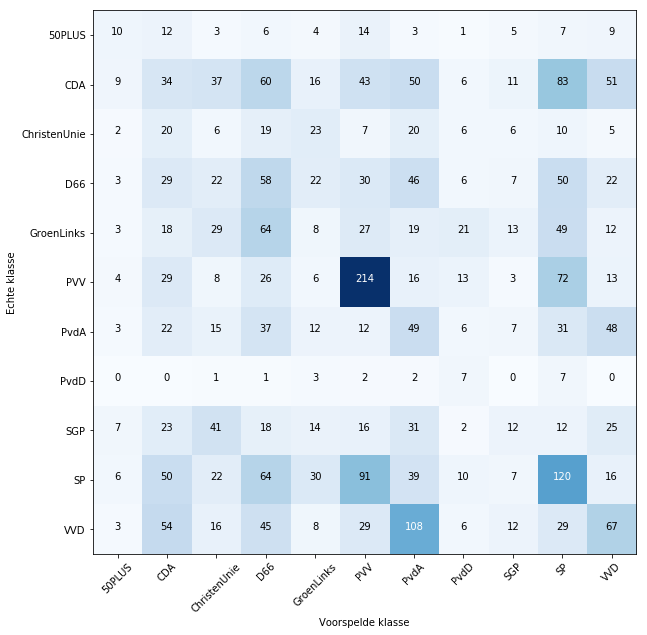

In [45]:
pipe = traintest('Scores.xlsx', df ,save="taalgebruik")

In [46]:
mostimportantwords(pipe, countdf, 'taalgebruik')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,inwoner,rookvrij,mijn fractie,huishoud zorg,miljard,circulair,bio industrie,mevrouw de voorzitter,huurder,wellicht
1,koopkrachtontwikkel,microplastic,gezinn,buitengewon,kinder die,islamitisch,open standaard,de bio,mevrouw de,country,aruba
2,vor gepensioneerd,PARTIJ fractie,voedselverspill,natur,geworteld,nederland,ieder kind,klimaatverander,eenverdiener,segregatie,volgen mij
3,ouderenwerklos,zorginstell,inderdad,hervorm,verhur,brussel,gezamen,bio,punt,zegt,essentieel
4,de koopkrachtontwikkel,reger,horeca,helder,aan dat,asielzoeker,circulair economie,de bio industrie,nar vor,eigen,aangegev
5,werkend,echt,koerd,onderbouw,mensenrecht,belastingbetaler,hulpverlener,milieu,benader,bureaucratie,daadwerk
6,ouder,antwoord,gezinn met,vandag,pand,dit kabinet,en,dier,vanuit,te regel,kader
7,mevrouw de voorzitter,ruling,steunpakket,belangrijk dat,asielket,al,daarbij,industrie,allereerst,armoed,van aruba
8,mevrouw de,hier,ik constater,kans,flexwerker,ontwikkelingshulp,voorzitter PARTIJ,aan de bio,bewindslied,voorstell,arbeidsongeschikt
9,mens thuis,uiteind,valleilijn,vingerafdruk,tijdelijk verhur,verzorgingshuiz,eigenar,de natur,vor de beantwoord,groeiend,bct


# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.xlsx
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/WoordenBalkenende41.tex
!git add Verslag/Tables/WoordenBalkenende42.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/Correlation.png
!git add Verslag/Tables/confusionmatrix.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Verslag/Tables/Totaal.png
!git add Verslag/Tables/Mix.png
!git add Verslag/Tables/withoutnames.tex
!git add Verslag/Tables/taalgebruik.tex
!git add Verslag/Tables/onlynames.tex
!git add Verslag/Tables/Regering.png
!git add Verslag/Tables/Oppositie.png
!git add Models.xlsx
!git add Verslag/Tables/confusionmatrix.png
!git commit -m Update
!git push